In [1]:
from google.colab import drive

# drive.mount("/content/gdrive", force_remount=True)
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Setup

In [2]:
# Install SimpleITK
!pip install SimpleITK

In [3]:
import os

saliencies_and_segmentations_v2_path = "/content/gdrive/My Drive/saliencies_and_segmentations_v2"

def get_path_to_saliencies_and_segmentations(sub_path):
  return os.path.join(saliencies_and_segmentations_v2_path, sub_path)

# Conv-net (from ./conv_net.ipynb)

## MRISequence

In [4]:
import os
import math

import sklearn
import numpy as np
import SimpleITK as sitk

from keras.utils import Sequence

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from skimage.transform import resize


def process_image(path, input_shape, resize_img, normalization):
    x = sitk.GetArrayFromImage(sitk.ReadImage(path))
    if resize_img == True:
      x = resize(x, input_shape[:3])
    if normalization is not None:
      x = normalize(x, normalization)
    return np.array(x).reshape(input_shape)

def invert_img(x):
    # [x, y, z, 1]
    return x[:, :, ::-1, :]

def normalize(x, normalization):
    desc = normalization['desc']
    if normalization['type'] != 'standardization':
      return (x - desc['min']) / (desc['max'] - desc['min'])
    return (x - desc['mean']) / desc['std']

def augment_image(x, augment):
    if augment is None:
      return x

    if 'random_swap_hemispheres' in augment:
        p = augment['random_swap_hemispheres']
        if np.random.uniform(0) < p:
          return invert_img(x)

    return x

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class MRISequence(Sequence):
    def __init__(self,path, batch_size, input_shape, class_names=['AD', 'CN'], 
                 augment=None, images=True, one_hot=True, class_weight=None,
                 normalization=None, resize_img=True):
      if one_hot == False:
        self.encoder = LabelEncoder()
        self.encoder.fit(np.array(class_names))
      else:
        self.encoder = OneHotEncoder(sparse=False)
        self.encoder.fit(np.array(class_names).reshape(-1, 1))

      self.class_weight = class_weight
      self.one_hot = one_hot
      self.input_shape = input_shape
      self.resize_img = resize_img
      self.class_names = class_names
      self.images = images
      self.augment = augment
      self.normalization = normalization

      self.batch_size = batch_size
      self.images_dirs = [os.path.join(path, key) for key in os.listdir(path)]
        
    def __len__(self):
        return math.ceil(len(self.images_dirs) / self.batch_size)
        # Uncomment for debugging (when you need a smaller subset of data and faster training time)
        # return math.ceil(9 / self.batch_size)

    def __getitem__(self, idx):
        images_dirs = self.images_dirs[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        if not len(images_dirs):
          return np.array([]).reshape(-1, input_shape), np.array([]).reshape(-1, input_shape)

        # if we disabled loading images, don't do it
        if not self.images:
          batch_x = np.array([None for image_dir in images_dirs])
        else:
          batch_x = np.array([process_image(os.path.join(image_dir, 'data.nii'), self.input_shape, self.resize_img, self.normalization) for image_dir in images_dirs])
          batch_x = np.array([augment_image(x, self.augment) for x in batch_x])

        batch_y = self.__encode(np.array([self.__readfile(os.path.join(image_dir, 'real_diagnosis.txt')) for image_dir in images_dirs]))
        
        if self.class_weight is None:
          return batch_x, batch_y
        
        batch_w = np.array([self.class_weight[y] for y in self.__decode(batch_y)])
        return batch_x, batch_y, batch_w

    def __encode(self, labels):
      if self.one_hot == True:
        labels = labels.reshape(-1, 1)
      return self.encoder.transform(labels)

    def __decode(self, labels):
      if self.one_hot == True:
          return np.argmax(labels, axis=1)
      return labels

    def __readfile(self, file_path):
        fo = open(file_path, "r")
        c = fo.readline()
        fo.close()
        return c

## train_test_split

In [5]:
import os
import time
import shutil
import numpy as np

from tqdm import tqdm


def train_test_split(src, dst, **kwargs):
  split = kwargs.get('split', (0.8, 0.1, 0.1))
  dirname = kwargs.get('dirname', str(int(time.time())))

  if len(split) != 3:
    raise "split mus be length of three!"

  if sum(split) != 1:
    raise "sum of split must be 1!"

  dst_dir = os.path.join(dst, f'{dirname}')
  train_dir = os.path.join(dst_dir, 'train')
  test_dir = os.path.join(dst_dir, 'test')
  val_dir = os.path.join(dst_dir, 'val')
  
  if os.path.exists(dst_dir):
    print("not copying files since the destination directory already exists")

    return train_dir, test_dir, val_dir

  os.mkdir(dst_dir)
  print(f"copying to {dst_dir}...\n")

  # list of directories to copy
  src_dirs = os.listdir(src)
  print('shuffling an array...')
  np.random.shuffle(src_dirs)

  print('copying files...')
  src_dirs_count = len(src_dirs)
  for idx, dir in tqdm(enumerate(src_dirs), total=src_dirs_count):
    dst_dir = train_dir

    if idx > split[0] * src_dirs_count:
      dst_dir = test_dir
    if idx > (split[0] + split[1]) * src_dirs_count:
      dst_dir = val_dir

    shutil.copytree(os.path.join(src, dir), os.path.join(dst_dir, dir))

  return train_dir, test_dir, val_dir

### get_description

In [6]:
def get_description(norm_seq, max_samples=64):
  train_x = []  

  for index, batch in enumerate(norm_seq):
      batch_x, _ = batch                     
      for x in batch_x:
        train_x.append(x)
      if max_samples is not None and len(train_x) >= max_samples:
        break
  
  return {'mean': np.mean(train_x), 'std': np.std(train_x), 'min': np.min(train_x), 'max': np.max(train_x) }

## MRITensorBoardCallback

In [7]:
import io
import os
import itertools
import matplotlib.pyplot as plt

from keras.callbacks import Callback


def to_rgb_image(img, pred_label=None, true_label=None, z_index=None, add_batch_dim=True):
  figure = plt.figure(figsize=(4, 4))
  plt.imshow(img.reshape(img.shape[:-1])[z_index], cmap='gray')
  if true_label is not None and pred_label is not None:
    plt.title(f'true = {true_label}, pred = {pred_label}')
  return plot_to_image(figure, add_batch_dim)


def plot_to_image(figure, add_batch_dim=True):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside 
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  if add_batch_dim:
    # Add the batch dimension
    image = tf.expand_dims(image, 0)  
  return image


def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix', fontsize=36)
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = 'white' if cm[i, j] > threshold else 'black'
    plt.text(j, i, labels[i, j], horizontalalignment='center', color=color, fontsize=18)

  plt.tight_layout()
  plt.ylabel('True label', fontsize=18)
  plt.xlabel('Predicted label', fontsize=18)
  return figure


class MRITensorBoardCallback(Callback):
    def __init__(self, seq, model, z_index=56, max_outputs=18, freq=3, log_dir=None, debug=True):
        """
        seq is the sequence from which is the data taken
        model to fit
        z_index is the index in the 3D image which is visualised
        log_dir is the where is output logged
        max_outputs number of images to output
        freq determines how frequently (each freq epoch) to outpu to tensorboard
        """
        super(MRITensorBoardCallback, self).__init__()
        self.model = model
        self.seq = seq
        self.log_dir = log_dir
        self.z_index = z_index
        self.max_outputs = max_outputs
        self.freq = freq
        self.debug = debug

    def __get_z_index(self, img):
      return max(min(img.shape[1], self.z_index), 0)

    def __debug(self, msg):
      if self.debug:
        print(msg)

    def on_epoch_end(self, epoch, logs=None):
      if epoch % self.freq != 0:
        self.__debug('skipping evaluation of predictions to tensorboard')
        return

      self.__debug(f'evaluation of predictions to tensorboard for epoch #{epoch} (no of batches is {len(self.seq)})...')

      images = []
      class_names = self.seq.class_names
      y_pred = np.array([]).reshape(-1, len(class_names))
      y_true = np.array([]).reshape(-1, len(class_names))

      # Get predictions in batches for seq
      for index, batch in enumerate(self.seq):
        x, y, _ = batch
        self.__debug(f'batch #{index}')
        # Get predictions
        pred = self.model.predict(x)

        # Merge with other predictions
        y_true = np.concatenate([y_true, y])
        y_pred = np.concatenate([y_pred, pred])

        # Encode labels
        true_labels = self.seq.encoder.inverse_transform(y)
        pred_labels = self.seq.encoder.inverse_transform(pred)

        # Do not create more images than we output
        if len(images) >= self.max_outputs:
          continue;

        rgb_images = [to_rgb_image(image, pred_label=pred, true_label=true, z_index=self.z_index, add_batch_dim=False) for image, pred, true in zip(x, pred_labels.reshape(-1), true_labels.reshape(-1))]
        for rgb_image in rgb_images:
          images.append(rgb_image)

      # Create a confussion matrix
      cm = sklearn.metrics.confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
                                                                
      # Log the confusion matrix as an image summary.
      figure = plot_confusion_matrix(cm, class_names=class_names)
      cm_image = plot_to_image(figure)

      file_writer_cm = tf.summary.create_file_writer(os.path.join(self.log_dir, 'validation/confussion-matrix'))
      file_writer_images = tf.summary.create_file_writer(os.path.join(self.log_dir, 'validation/images'))

      with file_writer_images.as_default():
        # Don't forget to reshape.
        images = images[0:self.max_outputs]
        tf.summary.image("Validation Images", images, max_outputs=self.max_outputs, step=epoch)

      # Log the confusion matrix as an image summary.
      with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

## Evaluation

In [8]:
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_training_history(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 2, n + 1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_' + metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8, 1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [9]:
from sklearn.metrics import classification_report, mean_squared_error, mean_squared_log_error, explained_variance_score, f1_score, accuracy_score


def custom_classification_report(class_names, y_true, y_pred, **kwargs):
    clf_report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Custom print because of incorrect formatting of original function
    for key in clf_report:
        if isinstance(clf_report[key], dict):
            print(f'\033[1m{key}\033[0m')

            for metric in clf_report[key]:
                print(f'{metric}: {clf_report[key][metric]}')
        else:
            print(f'{key}: {clf_report[key]}')

        print('\n')
        
    print(f'\033[1mF1\033[0m')
    for average in ['micro', 'macro']:
        print(f'{average}: {f1_score(y_true, y_pred, average=average)}')

    print('\n')
    print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')

    print('\n')

In [10]:
def show_simple_metrics(model, test_seq):
  baseline_results = model.evaluate(test_seq, verbose=0)
  for name, value in zip(model.metrics_names, baseline_results):
    print(f'{name}: {value}')
  print()

In [11]:
def show_metrics(model, test_seq):
  y_true = np.array([]).reshape(-1, len(class_names))
  y_pred = np.array([]).reshape(-1, len(class_names))

  for batch in test_seq:
    x, y = batch

    pred = model.predict(x)
    
    y_true = np.concatenate([y_true, y])
    y_pred = np.concatenate([y_pred, pred])


  y_true_labels = test_seq.encoder.transform(test_seq.encoder.inverse_transform(y_true).reshape(-1, 1))
  y_pred_labels = test_seq.encoder.transform(test_seq.encoder.inverse_transform(y_pred).reshape(-1, 1))

  # Plot the confussion matrix
  cm = sklearn.metrics.confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
  plot_confusion_matrix(cm, class_names)

  # Plot the metrics
  custom_classification_report(class_names, y_true_labels, y_pred_labels)

## Model

### create_model()

In [12]:
import tensorflow as tf

from keras import Sequential
from keras.layers import Conv3D, MaxPool3D, Dense, Flatten, Dropout, Input, BatchNormalization
from keras.regularizers import L2

from keras.metrics import Recall, Precision, CategoricalAccuracy, AUC

from keras.losses import CategoricalCrossentropy, BinaryCrossentropy


def create_model(input_shape,
                 log_dir=None,
                 train_seq=None,
                 class_names=None,
                 output_bias=None,
                 normalization=None,
                 batch_norm=False,
                 is_complex=False,
                 **kwargs):
  """
  input_shape is (z, x, y, 1)
  log_dir of the tensorboard logs
  train_seq
  """
  # In the original paper, they experiment with dropout and L2 regularizers
  # they do not specify, where they put dropout layers, and on which layers they
  # apply what types of regularizations
  beta = kwargs.get('l2_beta', None) # TODO: add regularization to layers
  dropout= kwargs.get('dropout', None)

  model = Sequential()

  model.add(Input(shape=input_shape, name="input_layer"))
  
  # Preprocessing (normalization)
  if normalization is not None:
    model.add(Normalization())

  # THIS IS IMPLEMENTED IN SEQUENCE NOW
  # Augmention
  # model.add(RandomSwapBrainHemisphere(0.5))

  # NOT-WORKING
  # Debug output of previous layer to tensorboard as an image
  # Print the middle of the z index as an image
  # if log_dir is not None and train_seq is not None:
  #   model.add(Debug(
  #       log_dir=log_dir,
  #       log_key='augmented',
  #       log_name='Augmented Images',
  #       z_index=input_shape[0] // 2,
  #       # print only 2 batches from the epoch
  #       freq=len(train_seq) // 2,
  #       seq_len=len(train_seq)))

  # L1, L2
  # In the original paper they use input_shape=(116, 113, 83, 1), however it does not match
  # the proportions of our input shape
  model.add(Conv3D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
  
  if is_complex:
    model.add(Conv3D(32, kernel_size=3, activation='relu', padding='same'))

  if batch_norm == True:
    model.add(BatchNormalization())

  # L3
  model.add(MaxPool3D(pool_size=(2, 2, 2), padding='same'))

  # Dropout
  if dropout is not None:
    model.add(Dropout(dropout))

  # L4, L5
  model.add(Conv3D(64, kernel_size=3, activation='relu', padding='same'))

  if is_complex:
    model.add(Conv3D(64, kernel_size=3, activation='relu', padding='same'))

  if batch_norm == True:
    model.add(BatchNormalization())

  # L6
  model.add(MaxPool3D(pool_size=(3, 3, 3)))

  # Dropout
  if dropout == True:
    model.add(Dropout(dropout))

  # L7, L8
  model.add(Conv3D(128, kernel_size=3, activation='relu', padding='same'))

  if is_complex:
    model.add(Conv3D(128, kernel_size=3, activation='relu', padding='same'))

  if batch_norm == True:
    model.add(BatchNormalization())

  # L9
  model.add(MaxPool3D(pool_size=(4, 4, 4)))

  # Dropout
  if dropout is not None:
    model.add(Dropout(dropout))

  # Flatten
  model.add(Flatten())

  # L10
  if is_complex:
    model.add(Dense(512))

  if batch_norm == True:
    model.add(BatchNormalization())

  # Dropout
  if dropout is not None:
    model.add(Dropout(dropout))

  # L11
  model.add(Dense(256))

  if batch_norm == True:
    model.add(BatchNormalization())

  # Dropout
  if dropout is not None:
    model.add(Dropout(dropout))

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  # Output
  model.add(Dense(len(class_names), activation='softmax', bias_initializer=output_bias))

  # Finally compile the model!
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=kwargs.get('learning_rate', 0.001), beta_1=0.9, beta_2=0.999),
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
    loss=CategoricalCrossentropy(),
    # loss=BinaryCrossentropy(),
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
    metrics=[Recall(), Precision(), AUC(), CategoricalAccuracy()],
    # metrics=[CategoricalAccuracy()],
  )

  return model

### train()

In [13]:
import datetime


def train(model, train_seq, val_seq, **kwargs):
  global CHECKPOINT_DIRECTORY
  global LOG_DIRECTORY

  input_shape = train_seq.input_shape
  model_key = kwargs.get('model_key', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  print(f'model key: {model_key}')

  checkpoint_dir = os.path.join(CHECKPOINT_DIRECTORY, model_key)
  log_dir = os.path.join(LOG_DIRECTORY, model_key)
  image_log_dir = os.path.join(IMAGE_LOG_DIRECTORY, model_key)

  print(f'checkpoint dir - {checkpoint_dir}')
  print(f'log dir - {log_dir}')

  callbacks = [
      # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
      tf.keras.callbacks.TensorBoard(
          log_dir=os.path.join(log_dir),
          update_freq=4,
          histogram_freq=1,
          profile_batch=0
      ),
      tf.keras.callbacks.ModelCheckpoint(
          os.path.join(checkpoint_dir, 'cp-{epoch:04d}.ckpt'),          
          monitor='val_loss',
          save_weights_only=True,
          verbose=2,
          # save_best_only=True,
      ),
      # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping 
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=kwargs.get('patience', 10), # Number of epochs with no improvement after which training will be stopped.
          restore_best_weights=True,
      ),
      MRITensorBoardCallback(val_seq, model, z_index=input_shape[0] // 2, freq=1, log_dir=log_dir, debug=False),
  ]

  # train the model
  # https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
  print('training...')
  history = model.fit(
      train_seq,
      validation_data=val_seq,
      epochs=kwargs.get('epochs', 50),
      workers=1,
      verbose=1,
      callbacks=callbacks,
      class_weight=kwargs.get('class_weight', None),
  )

  return model, checkpoint_dir, history

## Training

In [14]:
import os

os.path.join('/content/gdrive/My Drive/', 'bckp-checkpoints')

TRAIN_MODEL=False
# no dropout
# CHECKPOINT_PATH=os.path.join('/content/gdrive/My Drive/', 'bckp-checkpoints', '20201110-113051', 'cp-0061.ckpt')
# with dropout
CHECKPOINT_PATH=os.path.join('/content/gdrive/My Drive/', 'bckp-checkpoints', '20201110-143615', 'cp-0067.ckpt')

In [15]:
print(CHECKPOINT_PATH)

/content/gdrive/My Drive/bckp-checkpoints/20201110-143615/cp-0067.ckpt


### Setup

In [16]:
%time

import os
import datetime

# https://github.com/timzatko/fiit-nsiete/blob/master/src/model.py

# constants
LOG_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'logs')
IMAGE_LOG_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'image-logs')
CHECKPOINT_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'checkpoints')

if not os.path.exists(CHECKPOINT_DIRECTORY):
  os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
  os.mkdir(LOG_DIRECTORY)

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/', split=(0.8, 0.15, 0.05), dirname='data-v2')

# set the batch size
batch_size = 12
input_shape = (112, 112, 105, 1)
resize_img=True

# batch_size = 4
# input_shape = (160, 160, 150, 1)
# resize_img=False

# if y is one-hot encoded or just scalar number
one_hot = True

# class weights (see analysis notebook)
class_weight = {0: 0.8271604938271606, 1: 1.2641509433962266}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
  print('initializing desc...')
  desc = get_description(MRISequence(
    train_dir,
    64,
    class_names=class_names,
    input_shape=input_shape), max_samples=None)
  print(desc)
  
normalization={'type':'normalization', 'desc':desc }
# normalization={'type':'standardization', 'desc':desc }

print('initializing train_seq...')
# initialize sequence
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augment={'random_swap_hemispheres': 0.5},
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing val_seq...')
val_seq = MRISequence(
    val_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    normalization=normalization)

# generate a model key for logs
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
not copying files since the destination directory already exists
initializing train_seq...
initializing val_seq...
initializing test_seq...
log_dir: /content/gdrive/My Drive/logs/20201114-125324


In [17]:
tf.config.run_functions_eagerly(False)

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([243/159])

model = create_model(
    input_shape,
    log_dir=log_dir, 
    train_seq=train_seq,
    class_names=class_names,
    # l2_beta=0.01,
    dropout=0.20,
    # dropout=None,
    output_bias=initial_bias,
    learning_rate=0.001,
    # normalization=normalization, # normalization layer
    # batch_norm=True,
    is_comlex=False, # a complex layer from the paper, max batch_size is 3
)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 112, 112, 105, 32) 896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 56, 56, 53, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 53, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 56, 56, 53, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 18, 18, 17, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 18, 18, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 4, 4, 128)      0

### Train / Load model

In [18]:
tf.executing_eagerly()
 
 
if TRAIN_MODEL:
  model, checkpoint_dir, history = train(
      model,
      train_seq,
      val_seq,
      model_key=model_key,
      epochs=75,
      patience=50,
  )
else:
  # checkpoint = tf.train.load_checkpoint(CHECKPOINT_PATH)
  model.load_weights(CHECKPOINT_PATH)

### Evaluation

In [19]:
if TRAIN_MODEL:
  plot_training_history(history)

In [20]:
%%time

show_simple_metrics(model, test_seq)

loss: 0.7409264445304871
recall: 0.7066666483879089
precision: 0.7066666483879089
auc: 0.7498666048049927
categorical_accuracy: 0.7066666483879089

CPU times: user 18.1 s, sys: 1.57 s, total: 19.7 s
Wall time: 19.2 s


AD
precision: 0.7884615384615384
recall: 0.7884615384615384
f1-score: 0.7884615384615384
support: 52


CN
precision: 0.5217391304347826
recall: 0.5217391304347826
f1-score: 0.5217391304347826
support: 23


micro avg
precision: 0.7066666666666667
recall: 0.7066666666666667
f1-score: 0.7066666666666667
support: 75


macro avg
precision: 0.6551003344481605
recall: 0.6551003344481605
f1-score: 0.6551003344481605
support: 75


weighted avg
precision: 0.7066666666666667
recall: 0.7066666666666667
f1-score: 0.7066666666666667
support: 75


samples avg
precision: 0.7066666666666667
recall: 0.7066666666666667
f1-score: 0.7066666666666667
support: 75


F1
micro: 0.7066666666666667
macro: 0.6551003344481605


accuracy_score: 0.7066666666666667


CPU times: user 15 s, sys: 1.04 s, total: 16 s
Wall time: 16.9 s


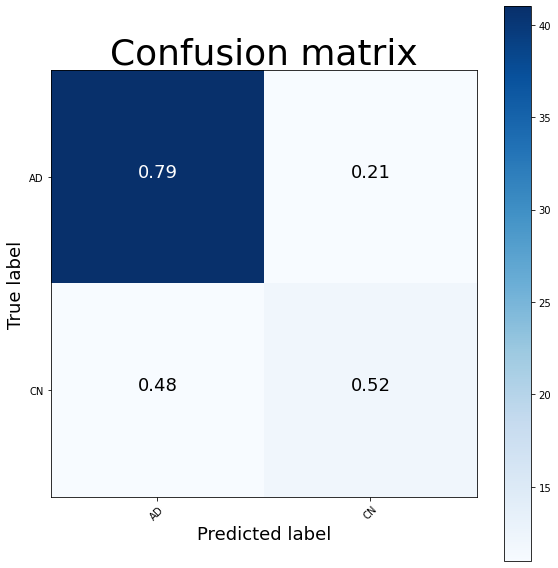

In [21]:
%%time

show_metrics(model, test_seq)

# RISEI

### Class

In [22]:
import os
import time
import cv2

import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.restoration import inpaint

from multiprocessing import Pool

from tensorflow.keras import preprocessing

from PIL import Image

def generate_mask(params):
    grid = params['grid']
    options = params['options']
    i = params['i']
    image_data = params['image_data']

    shift_x, shift_y, shift_z = __get_random_shift(options)

    # mask has a soft corners
    mask = __get_mask(options, grid, shift_x, shift_y, shift_z)
    # binary mask does not have a soft corners and is used for an inpainting
    binary_mask = __get_binary_mask(options, grid, shift_x, shift_y, shift_z)
    
    inpaint_mask = None
    if options['b1'] > 0:
      inpaint_mask = __get_inpaint_mask(options, image_data, binary_mask)
    
    new_image = __merge(options, image_data, mask, inpaint_mask)

    cache = None
    # when the debug mode is enabled
    # save the generated images to cache
    if options['debug']:
        cache = {
            'grid': grid,
            'binary_mask': binary_mask,
            'inpaint_mask': inpaint_mask,
        }

    return i, new_image, mask, cache

def __merge(options, original_image, mask, inpaint_mask):
    original_image = (original_image - original_image.min())

    # blend original image with inpaint mask if exists
    new_image = original_image

    if inpaint_mask is not None:
      new_image = (1 - options['b1']) * original_image + options['b1'] * inpaint_mask

    # blend original image with inpaint mask with mask
    new_image = new_image * (1 - ((1 - mask) * options['b2']))

    return new_image

def __get_inpaint_mask(options, image_data, binary_mask):
    if options['inpaint'] == '3d':
        return __get_inpaint_mask_3d(options, image_data, binary_mask)
    return __get_inpaint_mask_2d(options, image_data, binary_mask)


def __get_inpaint_mask_3d(options, image_data, binary_mask):
    start = time.time() 

    inverted_binary_mask = 1 - binary_mask.astype(np.uint8)
    inpainted = inpaint.inpaint_biharmonic(image_data, inverted_binary_mask, multichannel=False);
    
    end = time.time()  
    print(f"in: {end - start}")

    return inpained


def __get_inpaint_mask_2d(options, image_data, binary_mask):
    start = time.time() 
    
    inpainted = np.zeros(image_data.shape)
    inverted_binary_mask = (1 - binary_mask).astype(np.uint8)
      
    for z in range(0, image_data.shape[0]):
      inpainted[z] = cv2.inpaint(
          image_data[z],
          inverted_binary_mask[z],
          options['inpaint_radius'],
          options['inpaint_algorithm']
      )

    end = time.time()
    
    # print(f"in: {end - start}")

    return inpainted


def __get_random_shift(options):    
    shift_x = np.random.randint(0, options['over_image_size'][0])
    shift_y = np.random.randint(0, options['over_image_size'][1])
    shift_z = np.random.randint(0, options['over_image_size'][2])

    return shift_x, shift_y, shift_z


def __get_mask(options, grid, shift_x, shift_y, shift_z):
    return resize(grid,
                  options['mask_size'],
                  order=1,
                  mode='reflect',
                  anti_aliasing=False)[shift_y:shift_y + options['input_size'][0], shift_x:shift_x + options['input_size'][1], shift_z:shift_z + options['input_size'][2]]


def __get_binary_mask(options, grid, shift_x, shift_y, shift_z):
    new_grid = np.zeros(options['mask_size'])
    input_size = options['input_size']  
    start = time.time()

    for a in range(0, grid.shape[0]):
      for b in range(0, grid.shape[1]):
        for c in range(0, grid.shape[2]):
          x = a * options['cell_size'][0]
          y = b * options['cell_size'][1]
          z = c * options['cell_size'][2]

          new_grid[x:x + options['cell_size'][0], y:y + options['cell_size'][1], z:z + options['cell_size'][2]] = int(grid[a][b][c])
            
    end = time.time()
    # print(f"gbm: {end - start}")

    return new_grid[shift_x:input_size[0] + shift_x, shift_y:input_size[1] + shift_y, shift_z:input_size[2] + shift_z]


class RISEI():
    def __init__(self, input_size, **kwargs):
        self.options = {
            'input_size': input_size,
            's': kwargs.get('s', 8),  # size of the "grid" - binary mask
            'p1': kwargs.get('p1', 0.5),  # probability of cell being white - transparent
            'b1': kwargs.get('b1', 0.8),  # inpaint mask blend
            'b2': kwargs.get('b2', 0.5),  # black mask blend
            'inpaint': kwargs.get('inpaint', '2d'), # 3d, 2d
            'inpaint_radius': kwargs.get('inpaint_radius', 20),  # inpainting radius
            'inpaint_algorithm': kwargs.get('inpaint_algorithm', cv2.INPAINT_NS), # cv2.INPAINT_TELEA, cv2.INPAINT_NS
            'debug': kwargs.get('debug', False),
            'mask_size': None,
            'cell_size': None,
            'over_image_size': None,
            'processes': kwargs.get('processes', 4),
        }

        self.cache = None

        self.__get_grid_size()

    def generate_masks(self, N, image):
        self.__initialize_cache(N, image)

        grids = self.__get_empty_grids(N)        
        images_data = self.__get_empty_images_data(N)
        images_mask = self.__get_empty_images_data(N)
        
        params = [{ 'i': i, 'options': self.options, 'grid': grids[i], 'image_data': image } for i in range(0, N)]

        # use process pool only when more than a one process is used
        # in google colab it causes memory leaks
        if self.options['processes'] > 1:
          process_pool = Pool(processes=self.options['processes'])

          with process_pool as p:
              with tqdm(desc='Generating masks', total=N) as pbar:
                  for i, new_image, mask, cache in p.imap_unordered(generate_mask, params):
                      images_data[i, :, :, :] = new_image
                      images_mask[i, :, :, :] = mask

                      if cache is not None:
                          self.__save_to_cache(i, new_image, mask, cache)

                      pbar.update()
          
          process_pool.close()
        else:
          with tqdm(desc='Generating masks', total=N) as pbar:
            for i, new_image, mask, cache in map(generate_mask, params):
                images_data[i, :, :, :] = new_image
                images_mask[i, :, :, :] = mask

                if cache is not None:
                    self.__save_to_cache(i, new_image, mask, cache)

                pbar.update()

        return images_data, images_mask

    def show_from_last_run(self, i, z, figsize=(12, 8), ncols=3, nrows=2):
        original_image = self.show_image_from_last_run(i, z)
        mask = self.show_mask_from_last_run(i, z)
        binary_mask = self.show_binary_mask_from_last_run(i, z)
        inpaint = self.show_inpaint_from_last_run(i, z) if self.options['b1'] > 0 else self.show_image_from_last_run(i, z)
        result = self.show_result_from_last_run(i, z)

        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        ax = axes.ravel()

        ax[0].set_title('Original')
        ax[0].imshow(original_image)

        ax[1].set_title('Binary mask')
        ax[1].imshow(binary_mask)

        ax[2].set_title('Mask')
        ax[2].imshow(mask)

        ax[3].set_title('Inpaint')
        ax[3].imshow(inpaint)

        ax[4].set_title('Result')
        ax[4].imshow(result)

        for a in ax:
            a.axis('off')

        fig.tight_layout()
        plt.show()

    def show_mask_from_last_run(self, i, z):
        mask = self.__get_from_cache('masks', i)
        _, y, x = self.options['input_size']

        image = 255 * np.ones((y, x, 3), dtype=np.uint8)
        new_image = image * mask[z, :, :].reshape(self.options['input_size'][1], self.options['input_size'][2], 1)

        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_binary_mask_from_last_run(self, i, z):
        binary_mask = self.__get_from_cache('binary_masks', i)
        _, y, x = self.options['input_size']

        image = 255 * np.ones((y, x, 3), dtype=np.uint8)
        new_image = image * binary_mask[z, :, :].reshape(self.options['input_size'][1], self.options['input_size'][2], 1)

        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_image_from_last_run(self, i, z):
        if self.cache == None:
            raise Exception('Cache is not defined! Initialize algorithm with debug=True')

        return self.cache['image'][z, :, :]

    def show_inpaint_from_last_run(self, i, z):
        return self.__get_from_cache('inpaint_masks', i)[z, :, :]        

    def show_result_from_last_run(self, i, z):
        return self.__get_from_cache('images_data', i)[z, :, :]

    def __get_from_cache(self, key, i):
        if self.cache == None:
            raise Exception('Cache is not defined! Initialize algorithm with debug=True')
        if len(self.cache[key]) <= i:
            raise Exception(f'Index {i} does not exist!')
        return self.cache[key][i]

    def __save_to_cache(self, i, image_data, mask, cache):
        self.cache['images_data'][i] = image_data
        self.cache['masks'][i] = mask
        self.cache['grids'][i] = cache['grid']        
        self.cache['binary_masks'][i] = cache['binary_mask']
        self.cache['inpaint_masks'][i] = cache['inpaint_mask']

    def __initialize_cache(self, N, image):
        if self.options['debug']:
            self.cache = {
                'image': image,
                'images_data': np.empty((N, *self.options['input_size'])),
                'grids': np.empty((N, self.options['s'], self.options['s'], self.options['s'])),
                'masks': np.empty((N, *self.options['input_size'])),
                'binary_masks': np.empty((N, *self.options['input_size'])),
                'inpaint_masks': np.empty((N, *self.options['input_size'])),
            }
        else:
            self.cache = None
            
    def __get_empty_grids(self, N):
        grids = np.random.rand(N, self.options['s'], self.options['s'], self.options['s']) < self.options['p1']
        return grids.astype('float32')

    def __get_empty_images_data(self, N):
        return np.empty((N, *self.options['input_size']))
    
    def __get_grid_size(self):
        # the size of one pixel (rectangle)
        cell_size = np.ceil(np.array(self.options['input_size']) / self.options['s'])

        # the additional size for each rectangle
        # since we do a crop from the mask, we
        # need to make a "bigger" mask
        # we calculate how much we need to increase the cell
        # to increase the current size by one additional cell
        over_cell_size = np.ceil((((self.options['s'] + 1) * cell_size) - (self.options['s'] * cell_size)) / self.options['s'])

        # new cell size
        new_cell_size = cell_size + over_cell_size

        # mask size (mask is larger than the image)
        mask_size = (self.options['s'] * new_cell_size).astype(np.uint32)

        # difference in size between original image and mask
        over_image_size = mask_size - self.options['input_size']    

        self.options['mask_size'] = mask_size
        self.options['cell_size'] = new_cell_size.astype(np.uint32)
        self.options['over_image_size'] = over_image_size

## Generate

Generating masks: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


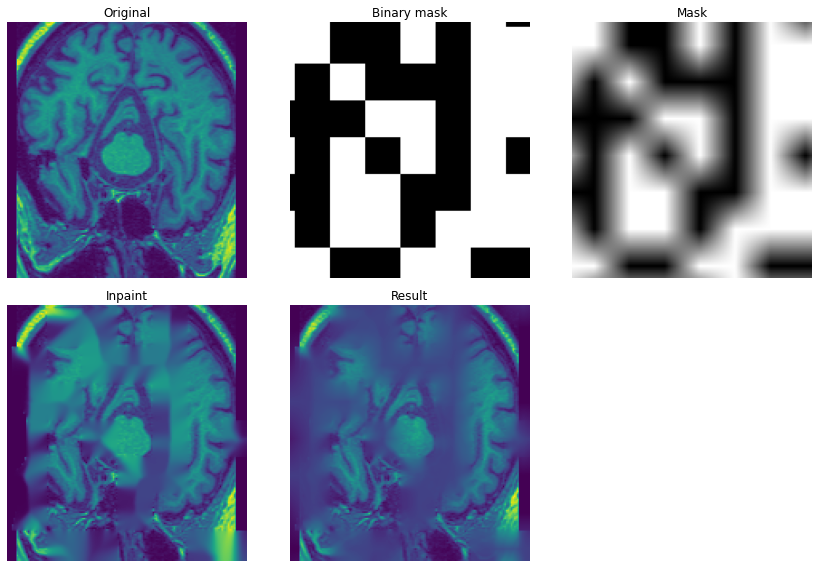

CPU times: user 4.08 s, sys: 259 ms, total: 4.34 s
Wall time: 4.11 s


In [23]:
%%time

raw_image = sitk.ReadImage(get_path_to_saliencies_and_segmentations("024_S_4280___2011-10-18___S125582/data.nii"))
image = sitk.GetArrayViewFromImage(raw_image)

risei = RISEI(image.shape, s=8, p1=0.5, b1=0.85, b2=0.9, inpaint="2d", inpaint_radius=5, processes=1, debug=True)

masks = risei.generate_masks(1, image)

risei.show_from_last_run(0, 60)

# Heatmaps


## Setup

In [24]:
def get_heatmap(x, y, model, risei, batch_size=8, masks_count=24, risei_batch_size=120, debug=False):
  """
  batch_size - model batch size
  """
  cls_idx = np.argmax(y)

  batch_count = math.ceil(masks_count / risei_batch_size)

  heatmap = np.zeros(shape=x.shape[:3])
  weights = 0

  masks_x = None if debug == False else []
  masks_y = None if debug == False else []

  for batch_idx in range(batch_count):
    if debug == True:
      print(f'\nbatch #{batch_idx} of {batch_count}')

    batch_masks_count = min(risei_batch_size, masks_count - batch_idx * risei_batch_size)
    # Reshape input to risei without channels,
    # then reshape masks back with channels.
    batch_x, masks = risei.generate_masks(batch_masks_count, x.reshape(x.shape[:3]))
    batch_y = [y for _ in range(batch_masks_count)]
    
    y_pred_per_mask = model.predict(batch_x.reshape((-1, *x.shape)), batch_size=batch_size)

    for mask, mask_x, y_pred in zip(masks, batch_x, y_pred_per_mask):
      # invert the mask, since 1 is for no masking
      # y is the activation for that class on the last layer
      heatmap = heatmap + y_pred[cls_idx] * (1 - mask)
      weights += y_pred[cls_idx]

      if debug == True:
        masks_x.append(mask_x)
        masks_y.append(y_pred[cls_idx])

  if debug == True:
    print(f'\n\ny_true: {cls_idx}')

  heatmap = heatmap / weights

  return heatmap, np.array(masks_x), np.array(masks_y)

In [25]:
from PIL import Image

import cv2
import math


def to_gray_scale(img):
    return (img * 255).astype(np.uint8)


def img_norm(image_x):
  return (image_x - image_x.min()) / (image_x.max() - image_x.min())


def show_heatmap(image_x, heatmap, z=None, alpha=0.5):
  """
  image_x - source image of shape (z, x, y, 1)
  heatmap - a generated heatmap of shape (z, x, y)
  """
  if z is None:
    z = math.ceil(image_x.shape[0] / 2)

  # we need to conver a colormap because 0 is red and 1 is blue
  heatmap_grayscale = to_gray_scale(1 - heatmap[z])
  heatmap_cmap = cv2.applyColorMap(heatmap_grayscale, cv2.COLORMAP_JET)

  image_x_grayscale = to_gray_scale(img_norm(image_x[z].reshape(image_x[z].shape[:2])))
  image_x_cmap = cv2.applyColorMap(image_x_grayscale, cv2.COLORMAP_BONE)

  return Image.blend(Image.fromarray(image_x_cmap, mode='RGB'), Image.fromarray(heatmap_cmap, mode='RGB'), alpha)

In [26]:
def show_mask(index, masks_x, masks_y, z):
  mask = masks_x[index]
  plt.title(f'y_pred:{masks_y[index]}')
  plt.imshow(mask[z].reshape(mask.shape[1:3]))

In [27]:
def plot_heatmap(image_x, image_y, y_pred, heatmap):  
  idx = np.argmax(image_y, axis=0)
  
  plt.subplot(1, 2, 1)
  plt.title(f'y_true: {idx}, y_pred: {y_pred}')
  plt.imshow(image_x.reshape(image_x.shape[:2]))
  plt.colorbar(fraction=0.046, pad=0.04)
  
  plt.subplot(1, 2, 2)
  plt.title(f'y_true: {idx}, y_pred: {y_pred}')
  plt.imshow(image_x.reshape(image_x.shape[:2]))
  plt.imshow(heatmap, cmap='jet', alpha=0.5)
  plt.colorbar(fraction=0.046, pad=0.04)
  
  plt.show()

def plot_heatmap_z(image_x, image_y, y_pred, heatmap, z):
  plot_heatmap(image_x[z, :, :], image_y, y_pred, heatmap[z, :, :])

def plot_heatmap_y(image_x, image_y, y_pred, heatmap, y):
  plot_heatmap(image_x[:, y, :], image_y, y_pred, heatmap[:, y, :])

def plot_heatmap_x(image_x, image_y, y_pred, heatmap, x):
  plot_heatmap(image_x[:, :, x], image_y, y_pred, heatmap[:, :, x])

## Generate

In [28]:
image_x = None
image_y = None

batch_x, batch_y = test_seq[4]
print(batch_y)

idx = 3 # 5, 3
image_x = batch_x[idx]
image_y = batch_y[idx]

print(f'y_true: {np.argmax(image_y)}')
y_pred = model.predict(np.array([image_x]))
print(f'y_pred: {np.argmax(y_pred)}')
print(y_pred)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
y_true: 1
y_pred: 1
[[0.22686958 0.7731304 ]]


### RISE

In [29]:
# Create a RISEI instance with a config.
# RISEI accepts shape without channels!
#
# p1 = probability of white place to be transparent
# b1 = inpaint mask blend (0 disables inpainting)
# b2 = black mask blend

risei = RISEI(image_x.shape[:3], s=8, p1=1/4, b1=0, b2=1, inpaint="2d", inpaint_radius=5, processes=1, debug=True)

In [30]:
%%time

debug = False

# get a heatmap for a prediciton
heatmap, masks_x, masks_y = get_heatmap(image_x, image_y, model, risei, batch_size=batch_size, masks_count=480, risei_batch_size=120, debug=debug)

Generating masks: 100%|██████████| 120/120 [00:28<00:00,  4.21it/s]


CPU times: user 1min 59s, sys: 5.04 s, total: 2min 4s
Wall time: 2min 3s


In [31]:
if debug:
  masks_y

In [32]:
if debug:
  show_mask(len(0), masks_x, masks_y, 50)

In [33]:
if debug:
  risei.show_from_last_run(0, 56)

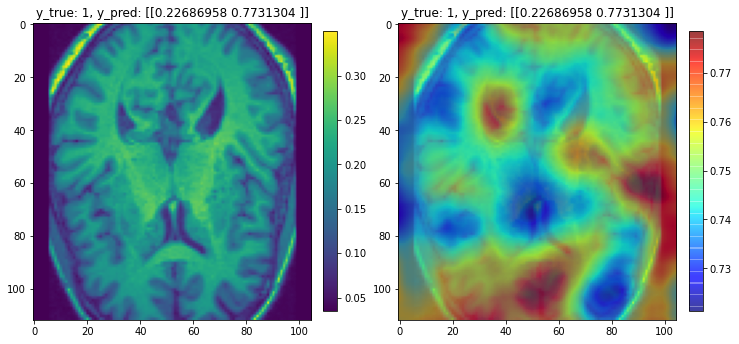

In [34]:
plot_heatmap_z(image_x, image_y, y_pred, heatmap, 56)

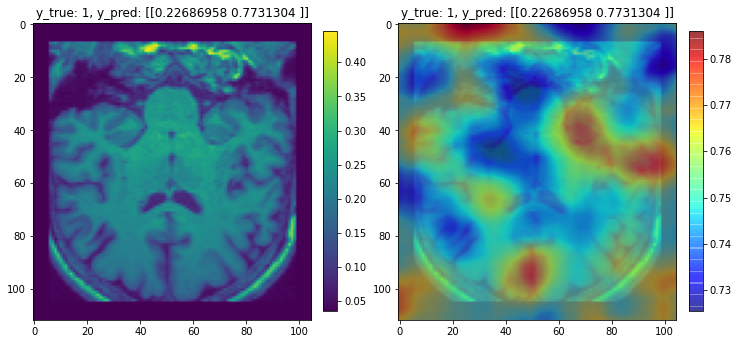

In [35]:
plot_heatmap_y(image_x, image_y, y_pred, heatmap, 56)

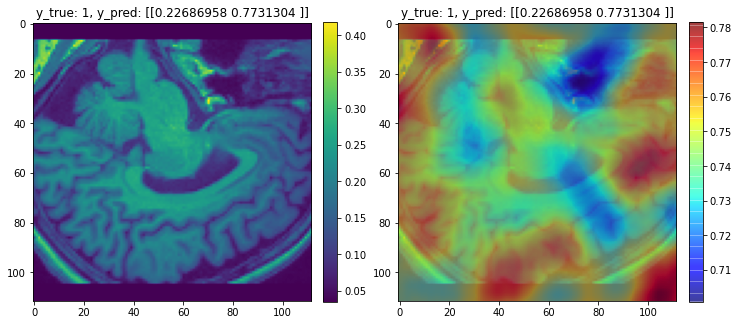

In [36]:
plot_heatmap_x(image_x, image_y, y_pred, heatmap, 56)

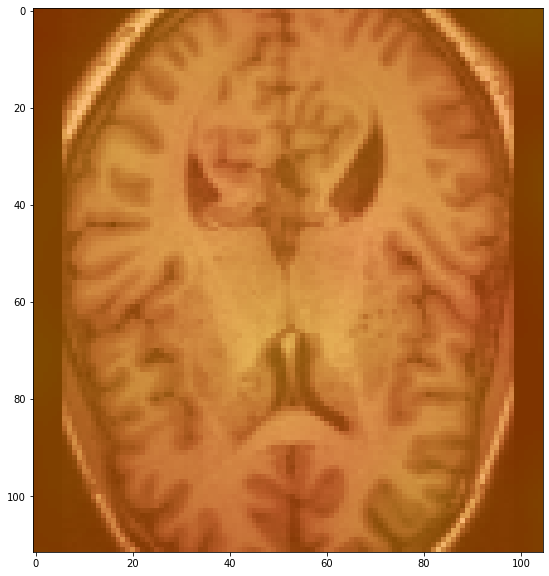

In [37]:
plt.imshow(show_heatmap(image_x, heatmap, z=56, alpha=0.5))

### RISEI

In [38]:
risei = RISEI(image_x.shape[:3], s=8, p1=1/3, b1=1, b2=0.8, inpaint="2d", inpaint_radius=5, processes=1, debug=True)

In [39]:
%%time

# get a heatmap for a prediciton
heatmap, masks_x, masks_y = get_heatmap(image_x, image_y, model, risei, batch_size=batch_size, masks_count=480, risei_batch_size=120, debug=True)

Generating masks:   0%|          | 0/120 [00:00<?, ?it/s]


batch #0 of 4


Generating masks:   0%|          | 0/120 [00:00<?, ?it/s]


batch #1 of 4


Generating masks:   0%|          | 0/120 [00:00<?, ?it/s]


batch #2 of 4


Generating masks:   0%|          | 0/120 [00:00<?, ?it/s]


batch #3 of 4


Generating masks: 100%|██████████| 120/120 [03:08<00:00,  1.57s/it]




y_true: 1
CPU times: user 12min 41s, sys: 7.55 s, total: 12min 49s
Wall time: 12min 47s


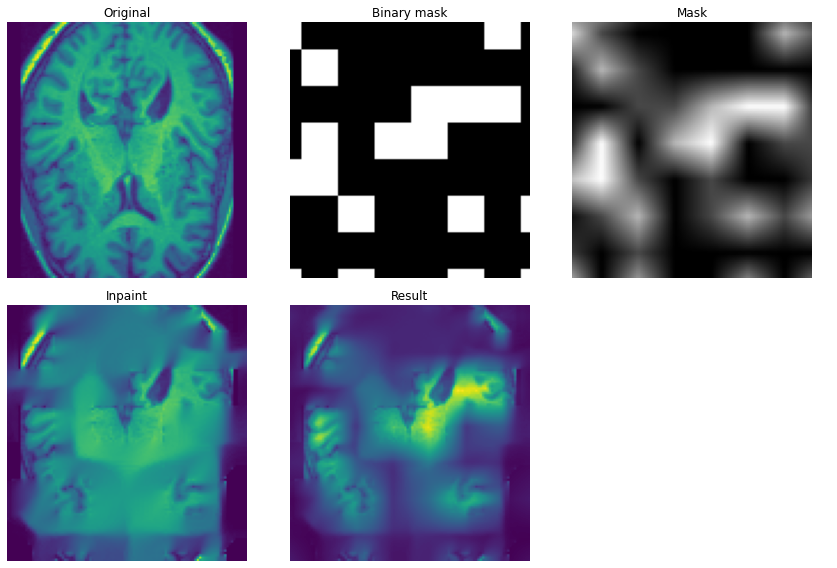

In [40]:
risei.show_from_last_run(0, 56)

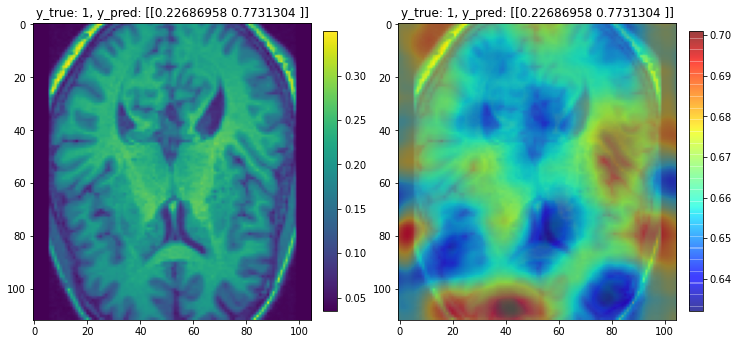

In [41]:
plot_heatmap_z(image_x, image_y, y_pred, heatmap, 56)

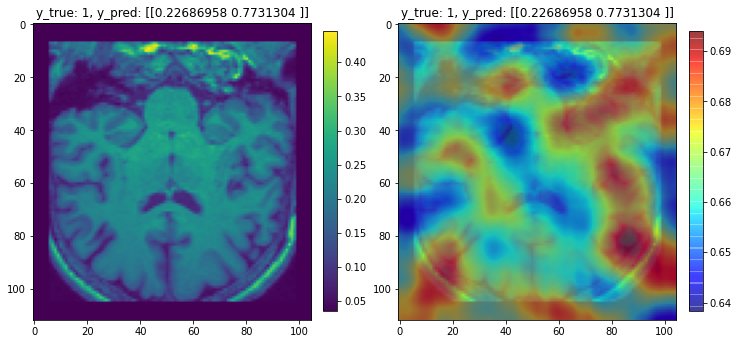

In [42]:
plot_heatmap_y(image_x, image_y, y_pred, heatmap, 56)

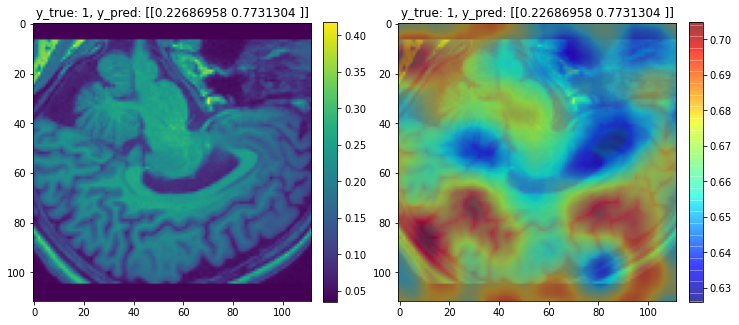

In [43]:
plot_heatmap_x(image_x, image_y, y_pred, heatmap, 56)

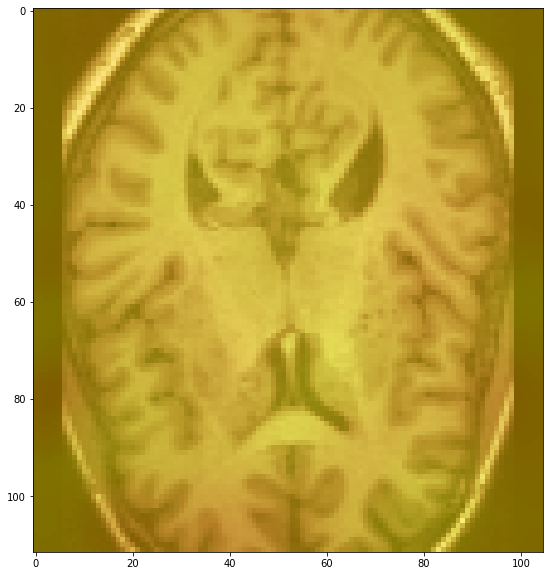

In [44]:
plt.imshow(show_heatmap(image_x, heatmap, z=56, alpha=0.5))

## Evaluation

### Setup

In [45]:
def plot_image(image_x):  
  plt.imshow(image_x.reshape(image_x.shape[:2]))


def plot_image_z(image_x, z):
  plot_image(image_x[z, :, :])


def plot_image_y(image_x, y):
  plot_image(image_x[:, y, :])


def plot_image_x(image_x, x):
  plot_image(image_x[:, :, x])

In [46]:
def my_cmp(v):
  return v[0]


# [heat, voxel, (z, y, x)]
def value_to_index(heatmap, image_x, sort='ASC'):
  values = []
  
  for z, _ in enumerate(heatmap):
    for y, _ in enumerate(heatmap[z]):
      for x, _ in enumerate(heatmap[z][y]):
        heat = heatmap[z][y][x]
        voxel = image_x[z][y][x]
        values.append((heat, voxel, (z, y, x)))

  reverse = sort == 'DESC'
  values.sort(reverse=reverse, key=my_cmp)

  return np.array(values)

In [47]:
class EvaluationSequence(Sequence):
    def __init__(self, t, image, heatmap, step_size=1, max_steps=1000, batch_size=8, debug=False, log=True):
      self.t = t
      self.log = log
      self.debug = debug
      self.batch_size = batch_size
      self.image = image
      self.heatmap = heatmap
      
      # cache the images if debug is enabled
      self.cache = []

      # this is insertion
      # [heat, voxel, (z, y, x)]
      self.voxels = value_to_index(heatmap, image, sort='DESC')

      if self.t == 'insertion':
        self.new_image = np.zeros(shape=image.shape)
      else:
        self.new_image = np.copy(image)

      self.step_size = step_size
      self.steps = 0
      self.max_steps = self.__get_max_steps(max_steps)
      self.max_voxels = self.max_steps * step_size

      self.tqdm = None
      if self.log == True:
        self.tqdm = tqdm(total=self.__len__())
        
    def __len__(self):
      return math.ceil(self.max_steps / self.batch_size)

    def __getitem__(self, idx):
      batch_x = []
      if self.tqdm is not None:
        self.tqdm.update()
      
      for i in range(batch_size):
        step = idx * batch_size + i
        # print(f'step: {step}')

        if step >= self.max_steps:
          break;

        start = step * self.step_size
        end = start + self.step_size
        # print(f'{start},{end}')

        # select voxels to add to the image
        s_voxels = self.voxels[start:end]

        for _, voxel, index in s_voxels:
          z, y, x = index

          if self.t == 'insertion':
            # set the value to the voxel (on mutable image)
            self.new_image[z][y][x] = voxel
          else:
            # deletion, remove the voxel
            self.new_image[z][y][x] = 0
        
        # append a copy, because we will mutate the image in next step
        batch_x.append(np.copy(self.new_image))

        if self.debug == True:
          self.cache.append(np.copy(self.new_image))

      batch_x = np.array(batch_x).reshape(-1, *self.new_image.shape)

      return batch_x

    def __get_max_steps(self, max_steps):
      return min(math.ceil(len(self.voxels) / self.step_size), max_steps)

In [48]:
import sklearn


def get_curve(image_y, y_pred, step_size):
  idx = image_y.argmax(axis=0)
  y = y_pred[:, idx]
  x = np.array(list(map(lambda s: s * step_size, range(len(y)))))
  return x, y


def evaluation_auc(image_y, y_pred, step_size):
  x, y = get_curve(image_y, y_pred, step_size)
  return sklearn.metrics.auc(x, y)


def plot_evaluation(image_y, y_pred, eval_seq, title='insertion'):
  idx = image_y.argmax(axis=0)
  x, y = get_curve(image_y, y_pred, eval_seq.step_size)
  auc = evaluation_auc(image_y, y_pred, eval_seq.step_size)
  plt.title(f'{title}: auc={auc}, y_true={idx}, voxel_count:{eval_seq.max_voxels:,} / {len(eval_seq.voxels):,})')
  plt.plot(x, y, linewidth=2)
  ax = plt.gca()
  ax.set_ylabel(f'activation')
  ax.set_xlabel(f'voxels')

### Insertion

In [49]:
%%time

eval_seq = EvaluationSequence(
    'insertion',
    image_x,
    heatmap,
    step_size=10,
    max_steps=100000,
    batch_size=batch_size,
    debug=False,
    log=False
)
y_pred = model.predict(eval_seq)

CPU times: user 21min 16s, sys: 6min 5s, total: 27min 22s
Wall time: 16min


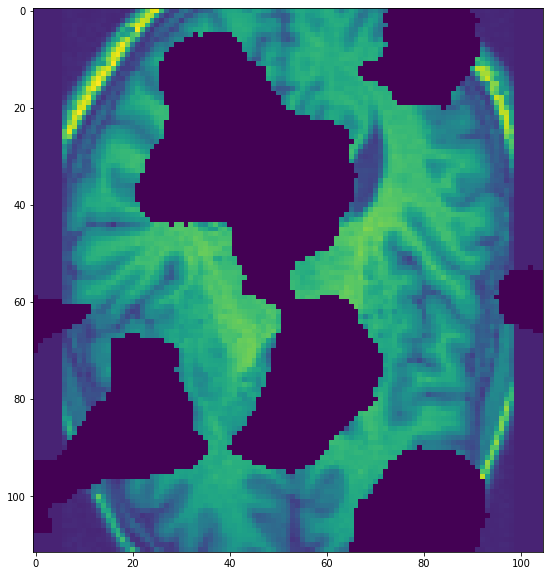

In [50]:
plot_image_z(eval_seq.new_image, 56)

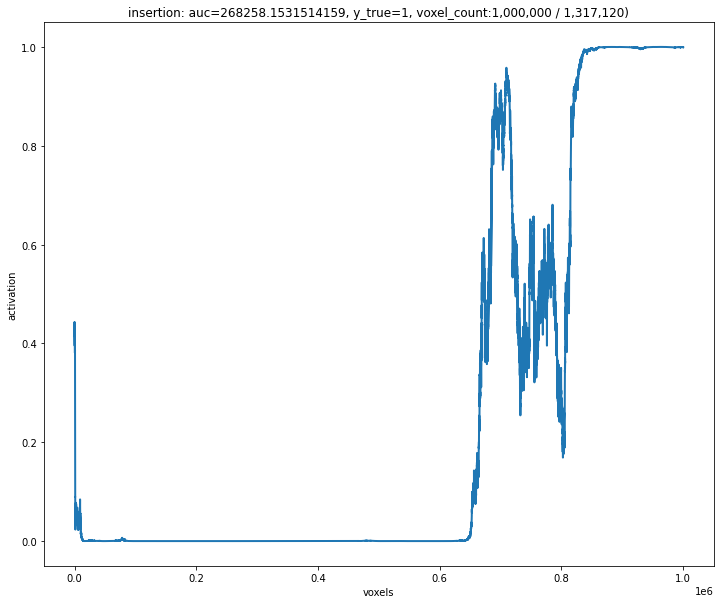

In [51]:
plot_evaluation(image_y, y_pred, eval_seq, title='insertion')

### Deletion

In [52]:
%%time

eval_seq = EvaluationSequence(
    'deletion',
    image_x,
    heatmap,
    step_size=10,
    max_steps=100000,
    batch_size=batch_size,
    debug=False,
    log=False
)
y_pred = model.predict(eval_seq)

CPU times: user 17min 42s, sys: 6min 2s, total: 23min 44s
Wall time: 16min


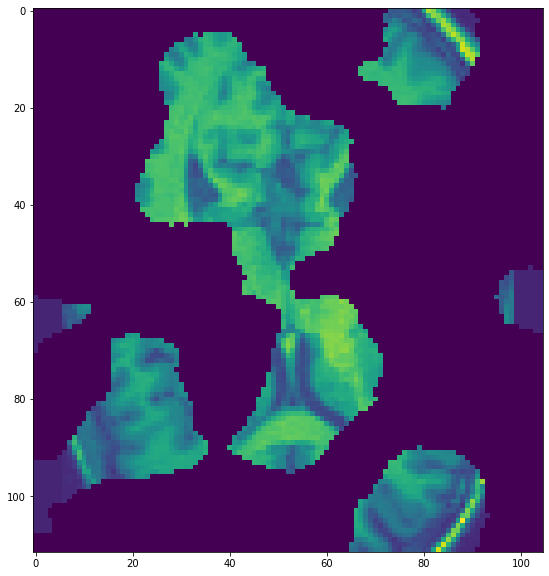

In [53]:
plot_image_z(eval_seq.new_image, 56)

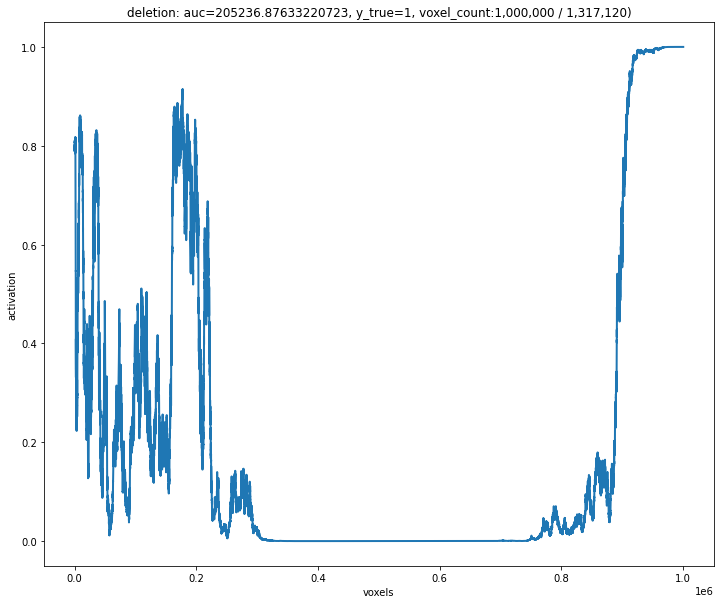

In [54]:
plot_evaluation(image_y, y_pred, eval_seq, title='deletion')